In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

In [2]:
# REPRODUCIBILITY
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# CONFIG
TRAIN_PATH = "LSTM-Multivariate_pollution.csv"
TEST_PATH = "pollution_test_data1.csv"

LAG = 12
ROLL_WINDOW = 3

# LOAD DATA
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [3]:
# Drop date column if exists
if "date" in df_train.columns:
          df_train = df_train.drop(columns=["date"])
if "date" in df_test.columns:
          df_test = df_test.drop(columns=["date"])
          
# Ensure consistent column order
cols = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]
df_train = df_train[cols]
df_test = df_test[cols]
df_train

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [4]:
df_test

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,128,-16,4,1027,SE,3.58,0,0
1,77,-17,5,1027,SE,7.60,0,0
2,65,-16,4,1027,SE,9.39,0,0
3,79,-16,1,1028,cv,0.89,0,0
4,93,-14,0,1028,NE,1.79,0,0
...,...,...,...,...,...,...,...,...
341,8,-23,-2,1034,NW,231.97,0,0
342,10,-22,-3,1034,NW,237.78,0,0
343,10,-22,-3,1034,NW,242.70,0,0
344,8,-22,-4,1034,NW,246.72,0,0


In [5]:
# HANDLE MISSING VALUES
num_cols = ["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain"]
cat_cols = ["wnd_dir"]

df_train[num_cols] = df_train[num_cols].interpolate(limit_direction="both", axis=0)
df_test[num_cols] = df_test[num_cols].interpolate(limit_direction="both", axis=0)

df_train[cat_cols] = df_train[cat_cols].ffill().bfill()
df_test[cat_cols] = df_test[cat_cols].ffill().bfill()

In [6]:
# FEATURE ENGINEERING: LAG & ROLLING
lag_rolling_train = []
for col in num_cols:
          # lag features
          for lag in range(1, LAG+1):
                    lag_rolling_train.append(df_train[col].shift(lag).rename(f"{col}_lag{lag}"))
          # rolling statistics
          roll = df_train[col].shift(1).rolling(ROLL_WINDOW)
          lag_rolling_train.extend([
                    roll.mean().rename(f"{col}_roll_mean{ROLL_WINDOW}"),
                    roll.std().rename(f"{col}_roll_std{ROLL_WINDOW}"),
                    roll.min().rename(f"{col}_roll_min{ROLL_WINDOW}"),
                    roll.max().rename(f"{col}_roll_max{ROLL_WINDOW}")
          ])
          
df_train = pd.concat([df_train] + lag_rolling_train, axis=1)

lag_rolling_test = []
for col in num_cols:
          # lag features
          for lag in range(1, LAG+1):
                    lag_rolling_test.append(df_test[col].shift(lag).rename(f"{col}_lag{lag}"))
          # rolling statistics
          roll = df_test[col].shift(1).rolling(ROLL_WINDOW)
          lag_rolling_test.extend([
                    roll.mean().rename(f"{col}_roll_mean{ROLL_WINDOW}"),
                    roll.std().rename(f"{col}_roll_std{ROLL_WINDOW}"),
                    roll.min().rename(f"{col}_roll_min{ROLL_WINDOW}"),
                    roll.max().rename(f"{col}_roll_max{ROLL_WINDOW}")
          ])

df_test = pd.concat([df_test] + lag_rolling_test, axis=1)

# Drop rows with NaN from lag/rolling
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df_train

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution_lag1,pollution_lag2,...,rain_lag7,rain_lag8,rain_lag9,rain_lag10,rain_lag11,rain_lag12,rain_roll_mean3,rain_roll_std3,rain_roll_min3,rain_roll_max3
12,148.0,-8,-5.0,1026.0,SE,23.69,0,0,152.0,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,164.0,-8,-5.0,1025.0,SE,27.71,0,0,148.0,152.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,158.0,-9,-5.0,1025.0,SE,31.73,0,0,164.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,154.0,-9,-5.0,1025.0,SE,35.75,0,0,158.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,159.0,-9,-5.0,1026.0,SE,37.54,0,0,154.0,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,NW,231.97,0,0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43796,10.0,-22,-3.0,1034.0,NW,237.78,0,0,8.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43797,10.0,-22,-3.0,1034.0,NW,242.70,0,0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43798,8.0,-22,-4.0,1034.0,NW,246.72,0,0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_test

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution_lag1,pollution_lag2,...,rain_lag7,rain_lag8,rain_lag9,rain_lag10,rain_lag11,rain_lag12,rain_roll_mean3,rain_roll_std3,rain_roll_min3,rain_roll_max3
12,160,-13,-7,1030,NW,2.68,0,0,170.0,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,146,-14,-9,1031,NW,4.47,0,0,160.0,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,125,-14,-8,1030,NW,7.60,0,0,146.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,130,-13,-6,1031,NW,8.49,0,0,125.0,146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,138,-14,-7,1031,NW,10.28,0,0,130.0,125.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,8,-23,-2,1034,NW,231.97,0,0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,10,-22,-3,1034,NW,237.78,0,0,8.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,10,-22,-3,1034,NW,242.70,0,0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,8,-22,-4,1034,NW,246.72,0,0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# PREPROCESSING
feature_cols = [c for c in df_train.columns if c != 'pollution']
target_col = 'pollution'

# Numeric/categorical separation
num_features = [c for c in feature_cols if df_train[c].dtype in [np.float32, np.float64, np.int32, np.int64]]
cat_features = [c for c in feature_cols if c not in num_features]

preprocessor = ColumnTransformer([
          ('num', MinMaxScaler(), num_features),
          ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
], remainder='drop'
)

X_train = preprocessor.fit_transform(df_train[feature_cols])
y_train = df_train[target_col].values
X_test = preprocessor.transform(df_test[feature_cols])
y_test = df_test[target_col].values

In [10]:
# DEFINE MODELS
models = {
          "LinearRegression": LinearRegression(),
          "Ridge": Ridge(),
          "Lasso": Lasso(),
          "ElasticNet": ElasticNet(),
          "DecisionTree": DecisionTreeRegressor(max_depth=10, random_state=SEED),
          "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=SEED),
          "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=SEED),
          "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=SEED, eval_metric='rmse'),
          "LightGBM": lgb.LGBMRegressor(n_estimators=200, random_state=SEED)
}

In [12]:
# TRAIN & EVALUATE
results = []
for name, model in models.items():
          model.fit(X_train, y_train)
          y_pred = model.predict(X_test)
          mae = mean_absolute_error(y_test, y_pred)
          mse = mean_squared_error(y_test, y_pred)
          rmse = np.sqrt(mse)
          r2 = r2_score(y_test, y_pred)
          results.append({
                    "Model": name,
                    "MAE": mae,
                    "MSE": mse,
                    "RMSE": rmse,
                    "R2": r2
          })
          
# Create DataFrame and sort by R2
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
print('\nModel Performance Ranking:')
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13757
[LightGBM] [Info] Number of data points in the train set: 43788, number of used features: 122
[LightGBM] [Info] Start training from score 94.001895

Model Performance Ranking:


c:\Users\Rayquaza\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Model,MAE,MSE,RMSE,R2
0,XGBoost,8.162232,156.841385,12.523633,0.983934
1,LightGBM,11.553300,421.820861,20.538278,0.956791
2,RandomForest,12.658809,481.842834,21.950919,0.950643
3,DecisionTree,12.786726,504.338874,22.457490,0.948339
4,GradientBoosting,13.267493,557.451023,23.610401,0.942898
5,LinearRegression,14.426038,636.382761,25.226628,0.934813
6,Ridge,14.410819,640.838926,25.314797,0.934357
7,Lasso,18.982116,849.486645,29.145954,0.912984
8,ElasticNet,65.151144,6843.544867,82.725721,0.298991


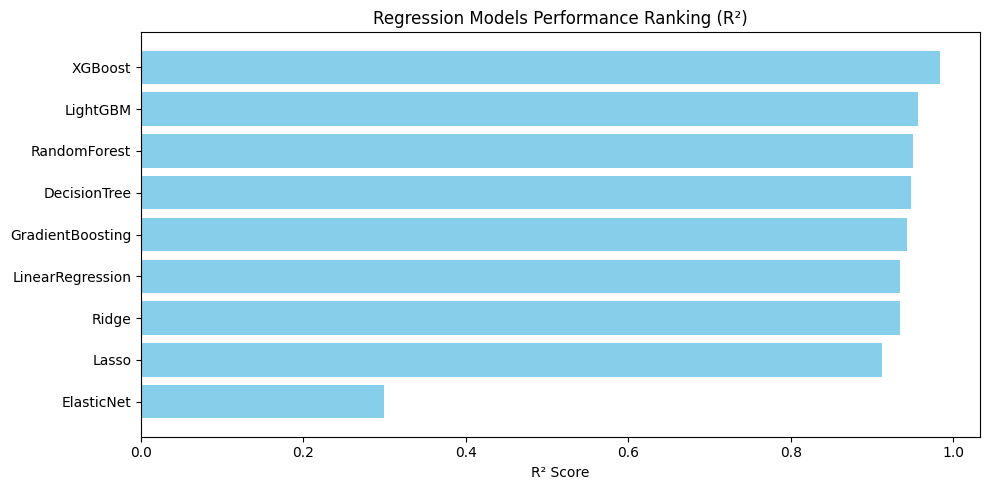

In [13]:
# PLOT RANKING BY x = range(3, 6)
plt.figure(figsize=(10,5))
plt.barh(results_df['Model'], results_df['R2'], color='skyblue')
plt.xlabel("R² Score")
plt.title("Regression Models Performance Ranking (R²)")
plt.gca().invert_yaxis()  # highest R2 on top
plt.tight_layout()
plt.show()